# Data

Open questions:
- where do we draw a line between smoothing and linking?
- are these good data or do we need some preprocessing?
    - like focus on short-distance relationships
    - split long distance tracksters in ground truth?

In [4]:
import uproot
import awkward as ak
import numpy as np
from reco.plotting import plot_event
from reco.energy import get_total_energy, get_energy_map
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map

# %matplotlib widget
%matplotlib inline

file_name = "~/Data/multi/new_ntuples_14992862_996.root"


tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

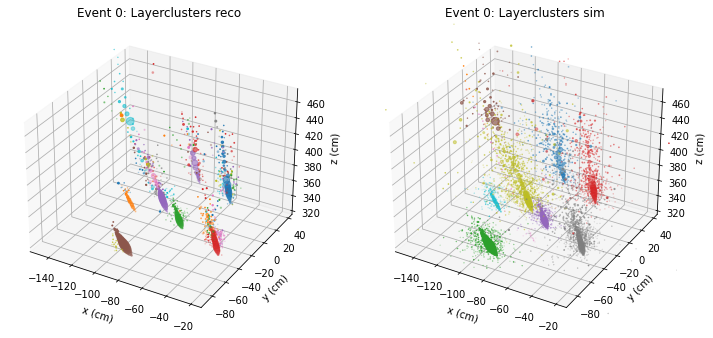

In [6]:
plot_event(tracksters, simtracksters, 0, legend=False)